In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
train_dir = '14_okakoro/train/'

# load training data
train_ds = image_dataset_from_directory(
    train_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size = (96,96),
    batch_size = 32
)

# validation data
validation_ds = image_dataset_from_directory(
    train_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (96,96),
    batch_size = 32
)

class_names = train_ds.class_names

Found 153 files belonging to 2 classes.
Using 123 files for training.
Found 153 files belonging to 2 classes.
Using 30 files for validation.


In /home/kenny/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kenny/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kenny/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/kenny/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kenny/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

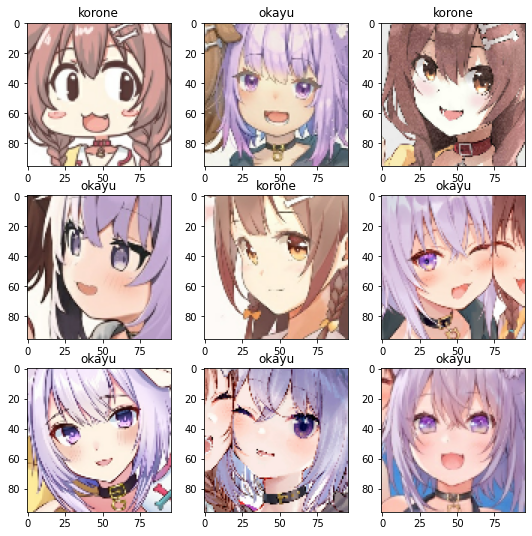

In [ ]:
# preview data
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 9))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])

In [ ]:
# configure performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000, reshuffle_each_iteration=True).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1)
])

# transfer learning 
# base_model = tf.keras.applications.MobileNetV2(input_shape=(96, 96, 3), weights='imagenet', include_top=False)
# base_model = tf.keras.applications.Xception(input_shape=(96, 96, 3), weights="imagenet", include_top=False)
base_model = tf.keras.applications.InceptionV3(input_shape=(96, 96, 3), weights="imagenet", include_top=False)
base_model.trainable = False

# stack layer
inputs = tf.keras.Input(shape=(96, 96, 3))
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()
# tf.keras.utils.plot_model(model, '14_okakoro/model.png', show_shapes=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
rescaling (Rescaling)        (None, 96, 96, 3)         0         
_________________________________________________________________
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

Epoch 1/10
4/4 - 4s - loss: 0.9986 - binary_accuracy: 0.5285 - val_loss: 0.6614 - val_binary_accuracy: 0.7667
Epoch 2/10
4/4 - 0s - loss: 0.7784 - binary_accuracy: 0.6423 - val_loss: 0.5054 - val_binary_accuracy: 0.7333
Epoch 3/10
4/4 - 0s - loss: 0.7080 - binary_accuracy: 0.6829 - val_loss: 0.4434 - val_binary_accuracy: 0.8000
Epoch 4/10
4/4 - 0s - loss: 0.4497 - binary_accuracy: 0.7724 - val_loss: 0.3855 - val_binary_accuracy: 0.8333
Epoch 5/10
4/4 - 0s - loss: 0.5261 - binary_accuracy: 0.7642 - val_loss: 0.3738 - val_binary_accuracy: 0.8333
Epoch 6/10
4/4 - 0s - loss: 0.3563 - binary_accuracy: 0.8455 - val_loss: 0.3395 - val_binary_accuracy: 0.8667
Epoch 7/10
4/4 - 0s - loss: 0.3792 - binary_accuracy: 0.8049 - val_loss: 0.3048 - val_binary_accuracy: 0.8667
Epoch 8/10
4/4 - 0s - loss: 0.3477 - binary_accuracy: 0.8211 - val_loss: 0.2910 - val_binary_accuracy: 0.8667

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 9/10
4/4 - 0s - loss: 0.3261 - bi

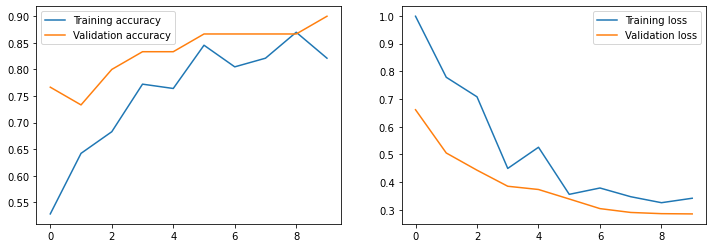

In [ ]:
# call back functions
earlystop = tf.keras.callbacks.EarlyStopping(patience=10)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_binary_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.5, 
    min_lr = 0.000001
)

model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
)

# initial training
epochs = 10
hist1 = model.fit(
    train_ds, 
    epochs = epochs, 
    validation_data = validation_ds, 
    verbose = 2, 
    callbacks = [earlystop, learning_rate_reduction]
)

plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 2, 1)
plt.plot(hist1.history['binary_accuracy'], label="Training accuracy")
plt.plot(hist1.history['val_binary_accuracy'],label="Validation accuracy")
plt.legend()
ax = plt.subplot(1, 2, 2)
plt.plot(hist1.history['loss'], label="Training loss")
plt.plot(hist1.history['val_loss'],label="Validation loss")
plt.legend()

130
Epoch 1/10
4/4 - 6s - loss: 0.2550 - binary_accuracy: 0.8618 - val_loss: 0.2296 - val_binary_accuracy: 0.9000
Epoch 2/10
4/4 - 2s - loss: 0.2162 - binary_accuracy: 0.9187 - val_loss: 0.2004 - val_binary_accuracy: 0.9000
Epoch 3/10
4/4 - 1s - loss: 0.2886 - binary_accuracy: 0.9106 - val_loss: 0.1512 - val_binary_accuracy: 0.9333
Epoch 4/10
4/4 - 1s - loss: 0.2060 - binary_accuracy: 0.9268 - val_loss: 0.1202 - val_binary_accuracy: 0.9333
Epoch 5/10
4/4 - 1s - loss: 0.1909 - binary_accuracy: 0.9106 - val_loss: 0.0970 - val_binary_accuracy: 0.9333

Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
Epoch 6/10
4/4 - 2s - loss: 0.1422 - binary_accuracy: 0.9431 - val_loss: 0.0923 - val_binary_accuracy: 0.9333
Epoch 7/10
4/4 - 1s - loss: 0.1465 - binary_accuracy: 0.9431 - val_loss: 0.0921 - val_binary_accuracy: 0.9667
Epoch 8/10
4/4 - 1s - loss: 0.0793 - binary_accuracy: 0.9675 - val_loss: 0.0904 - val_binary_accuracy: 0.9667
Epoch 9/10
4/4 - 1s - loss: 0.1149 

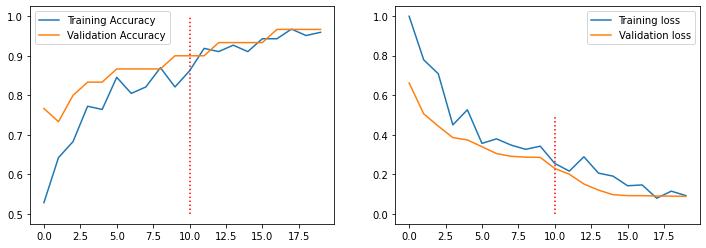

In [ ]:
# unfreeze base model
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable =  False

# recompile model
model.compile(
    optimizer = tf.keras.optimizers.Adam(1e-5),                      # Low learning rate
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = [tf.keras.metrics.BinaryAccuracy()],
)
print(len(model.trainable_weights))

# finetune training
epochs = 10
hist2 = model.fit(
    train_ds, 
    epochs = epochs, 
    validation_data = validation_ds, 
    verbose = 2, 
    callbacks = [earlystop, learning_rate_reduction]
)

plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 2, 1)
plt.plot(hist1.history['binary_accuracy'] + hist2.history['binary_accuracy'], label='Training Accuracy')
plt.plot(hist1.history['val_binary_accuracy'] + hist2.history['val_binary_accuracy'], label='Validation Accuracy')
plt.vlines(len(hist1.history['binary_accuracy']), 0.5, 1, color='r', linestyles='dotted')
plt.legend()
ax = plt.subplot(1, 2, 2)
plt.plot(hist1.history['loss'] + hist2.history['loss'], label="Training loss")
plt.plot(hist1.history['val_loss'] + hist2.history['val_loss'],label="Validation loss")
plt.vlines(len(hist1.history['binary_accuracy']), 0, 0.5, color='r', linestyles='dotted')
plt.legend()

incorrect classification: 1


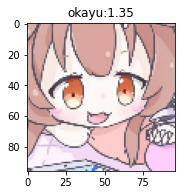

correct classification: 29


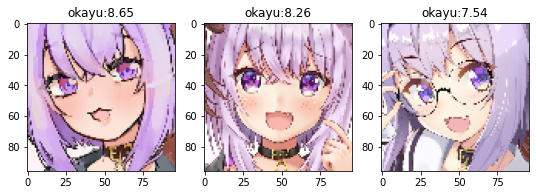

least confident


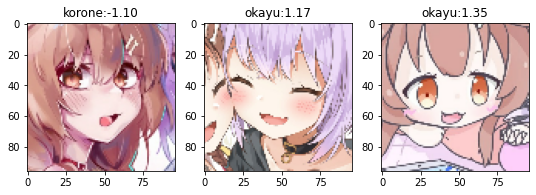

In [ ]:
import numpy as np

# confusion matrix
images, labels = next(iter(validation_ds))
pred = model.predict(images).reshape(-1,)
delta = np.abs(tf.math.sigmoid(pred) - tf.dtypes.cast(labels, tf.float32))
pred_labels = tf.dtypes.cast(np.round(tf.math.sigmoid(pred)), tf.int32)

confidence_order = np.argsort(np.abs(pred))
correctness_order = np.argsort(delta)
incorrect = np.abs((pred > 0) - labels)
incorrect_num = np.sum(incorrect)

# incorrect
print('incorrect classification:', incorrect_num)
plt.figure(figsize=(9, 3))
for i in range(incorrect_num):
    ax = plt.subplot(1, 3, i+1)
    j = correctness_order[-i-1]
    plt.imshow(images[j].numpy().astype("uint8"))
    plt.title('%s:%.2f' % (class_names[pred_labels[j]], pred[j]))
plt.show()

# correct
print('correct classification:', len(labels)-incorrect_num)
plt.figure(figsize=(9, 3))
for i in range(3):
    ax = plt.subplot(1, 3, i+1)
    j = correctness_order[i]
    plt.imshow(images[j].numpy().astype("uint8"))
    plt.title('%s:%.2f' % (class_names[pred_labels[j]], pred[j]))
plt.show()

# least confident
print('least confident')
plt.figure(figsize=(9, 3))
for i in range(3):
    ax = plt.subplot(1, 3, i+1)
    j = confidence_order[i]
    plt.imshow(images[j].numpy().astype("uint8"))
    plt.title('%s:%.2f' % (class_names[pred_labels[j]], pred[j]))
plt.show()

(array([4., 3., 3., 2., 0., 2., 2., 4., 7., 3.]),
 array([-7.1507564, -5.5706534, -3.9905505, -2.4104474, -0.8303445,
         0.7497585,  2.3298614,  3.9099643,  5.4900675,  7.0701704,
         8.650273 ], dtype=float32),
 <BarContainer object of 10 artists>)

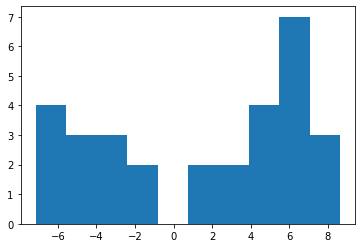

In [ ]:
# confident distribution
plt.hist(pred)

In [ ]:
# model.save('14_okakoro/model_v0.1', save_format='h5')
# model = tf.keras.models.load_model('14_okakoro/model_v0.1.h5')